# Convección en un gradiente de temperaturas lineal

Para realizar esta simulación tomé el modelo de `rayleigh_bernard` en dos dimensiones que venía en los ejemplos de dedalus, donde se resuelve para las variables de velocidad `(u, w)` y flotabilidad `b`, usando las siguientes ecuaciones:

$$\partial_x u + \partial_z w = 0,$$
$$\partial_t b - - P (\partial_{xx} b + \partial_{zz} b) - F * w = - u \partial_x b - w \partial_z b,$$
$$\partial_t u - R(\partial_{xx} u + \partial_{zz} u) + \partial_x P = - u \partial_x u - w \partial_z u,$$
$$\partial_t w - R(\partial_{xx} w + \partial_{zz} w) + \partial_z P = - u \partial_x w - w \partial_z w.$$

Ya que me interesa poner una estratificación como condición incial, expandí la flotabilidad como la diferencia de densidadades entre la parcela y una densidad promedio `ρ0`, donde la densidad de la parcela depende de la temperatura de la siguiente forma:

$$\rho = \rho_0 - \rho_0\alpha(T - T_0).$$

La ecuación que rige la transferencia de calor es la ecuación calórica:

$$\partial_t T  - \kappa (\partial_{xx} T + \partial_{yy} T) = - u \partial_x T  - v \partial_y T$$.

Las ecuaciones de continuidad y de Navier-Stokes, se mantienen igual.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
from dedalus import public as de
from dedalus.extras import flow_tools
import time
from IPython import display
from matplotlib import animation

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

## Dominio del problema

In [4]:
Lx, Ly = (0.2, 0.35)
nx, ny = (256, 256)

ν = 1.8e-6
T0 = 4.5
ρ0 = 999.9699
α = 8.1e-6
Prandtl = 1. #ν/α #0.22
Rayleigh = 5.8e7


x_basis = de.Fourier('x', nx, interval=(0, Lx))
y_basis = de.Chebyshev('y', ny, interval=(0, Ly))
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

## Ecuaciones

In [5]:
problem = de.IVP(domain, variables=['p', 'u', 'v', 'ρ', 'T', 'uy', 'vy', 'Ty'])

In [6]:
problem.meta['p', 'T', 'u', 'v', 'ρ']['y']['dirichlet'] = True

In [7]:
problem.parameters['P'] = (Rayleigh * Prandtl)**(-1/2)
problem.parameters['R'] = (Rayleigh / Prandtl)**(-1/2)
#problem.parameters['F'] = F = 1
problem.parameters['ρ0'] = ρ0
problem.parameters['T_0'] = T0 #10ºC
problem.parameters['K'] = 1.3e-7 
problem.parameters['g'] = 9.8
problem.parameters['α'] = α

problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(u) - R*(dx(dx(u)) + dy(uy)) + dx(p) = -(u*dx(u) + v*uy)")
problem.add_equation("dt(v) - R*(dx(dx(v)) + dy(vy)) + dy(p) = -(u*dx(v) + v*vy) - g*(ρ - ρ0)/ρ0")
problem.add_equation("ρ = ρ0 - ρ0*α*(T - T_0)")
problem.add_equation("dt(T) - K*(dx(dx(T)) + dy(Ty)) = - u*dx(T) - v*Ty")
problem.add_equation("Ty - dy(T) = 0")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")

problem.add_bc("left(T) = 5.0")
problem.add_bc("right(T) = 4.0")
problem.add_bc("left(u) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("right(p) = 0", condition="(nx == 0)")

## Condiciones de frontera

In [8]:
solver = problem.build_solver(de.timesteppers.RK222)

2017-06-13 21:51:02,655 pencil 0/1 INFO :: Building pencil matrix 1/128 (~1%) Elapsed: 0s, Remaining: 6s, Rate: 2.1e+01/s
2017-06-13 21:51:03,336 pencil 0/1 INFO :: Building pencil matrix 13/128 (~10%) Elapsed: 1s, Remaining: 6s, Rate: 1.8e+01/s
2017-06-13 21:51:03,945 pencil 0/1 INFO :: Building pencil matrix 26/128 (~20%) Elapsed: 1s, Remaining: 5s, Rate: 1.9e+01/s
2017-06-13 21:51:04,532 pencil 0/1 INFO :: Building pencil matrix 39/128 (~30%) Elapsed: 2s, Remaining: 4s, Rate: 2.0e+01/s
2017-06-13 21:51:05,208 pencil 0/1 INFO :: Building pencil matrix 52/128 (~41%) Elapsed: 3s, Remaining: 4s, Rate: 2.0e+01/s
2017-06-13 21:51:05,990 pencil 0/1 INFO :: Building pencil matrix 65/128 (~51%) Elapsed: 3s, Remaining: 3s, Rate: 1.9e+01/s
2017-06-13 21:51:06,719 pencil 0/1 INFO :: Building pencil matrix 78/128 (~61%) Elapsed: 4s, Remaining: 3s, Rate: 1.9e+01/s
2017-06-13 21:51:07,310 pencil 0/1 INFO :: Building pencil matrix 91/128 (~71%) Elapsed: 5s, Remaining: 2s, Rate: 1.9e+01/s
2017-06-13

## Condiciones iniciales

In [9]:
x = domain.grid(0)
y = domain.grid(1)
T = solver.state['T']
Ty = solver.state['Ty']
ρ = solver.state['ρ']

#### Perfil de temepratura lineal

In [10]:
yb, yt = y_basis.interval

In [11]:
yt

0.35

In [12]:
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)

In [13]:
y.shape

(1, 256)

In [14]:
a, b = T['g'].shape

In [15]:
b

256

In [16]:
T['g'] = np.random.rand(a, b)*1e-1 + 4.5

In [17]:
T['g']

array([[ 5.44237542,  5.48283424,  5.21591818, ...,  4.67920069,
         4.84228484,  4.79221843],
       [ 4.80373814,  4.93491927,  5.3288163 , ...,  5.07541991,
         5.27110465,  4.56108396],
       [ 4.88688111,  4.88486452,  5.31925091, ...,  5.37779651,
         4.51317271,  5.03761698],
       ..., 
       [ 4.55857894,  4.54676819,  4.88690544, ...,  4.56322371,
         4.58001764,  4.56657088],
       [ 4.7801623 ,  4.8278764 ,  5.19078264, ...,  4.50283436,
         4.63572188,  5.43542462],
       [ 4.67510536,  4.64271987,  4.67077106, ...,  5.44499315,
         5.34264365,  5.14149467]])

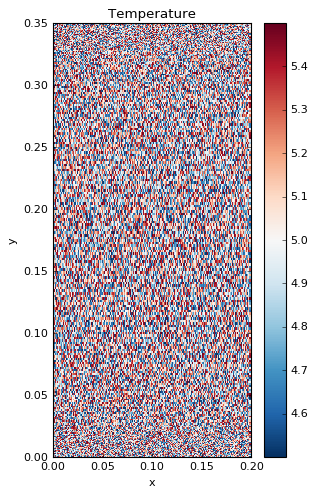

In [18]:
fig, axis = plt.subplots(figsize=(4,7))
pT = axis.pcolormesh(xm, ym, T['g'].T, cmap='RdBu_r');
plt.colorbar(pT)
plt.title('Temperature')
plt.xlabel('x')
plt.ylabel('y')

- $T0 = 4.0$. 
- $ρ0 = (999.9720 + 999.8395)/2$.
- $α = 8.1e-6$.

In [19]:
ρ['g'].shape

(256, 256)

In [20]:
ρ['g'] = ρ0 - ρ0*α*(T['g'] - T0)

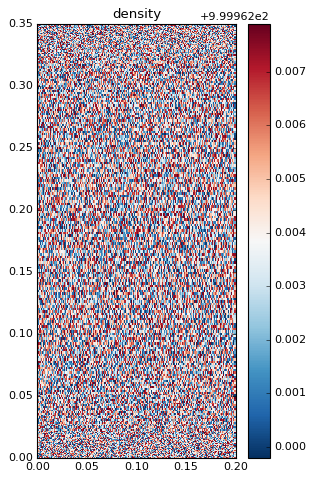

In [21]:
fig, axis = plt.subplots(figsize=(4,7))
pρ = axis.pcolormesh(xm, ym, ρ['g'].T, cmap='RdBu_r');
plt.colorbar(pρ)
plt.title('density')

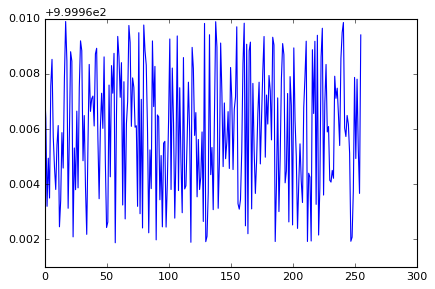

In [22]:
plt.plot(ρ['g'][1,:])

In [23]:
# Initial timestep
dt = 0.125
# Integration parameters
solver.stop_sim_time = 10
solver.stop_wall_time = 30 * 70.
solver.stop_iteration = np.inf

# Analysis
snapshots = solver.evaluator.add_file_handler('T_lineal', sim_dt=0.25, max_writes=100)
snapshots.add_system(solver.state)

# CFL
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=1,
                     max_change=1.5, min_change=0.5, max_dt=0.125, threshold=0.05)
CFL.add_velocities(('u', 'v'))

flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
flow.add_property("sqrt(u*u + v*v) / R", name='Re')

In [24]:
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.ok:
        #print("hola")
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            # Update plot of scalar field
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
            logger.info('Max Re = %f' %flow.max('Re'))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))

2017-06-13 21:53:05,436 __main__ 0/1 INFO :: Starting loop
2017-06-13 21:53:06,792 __main__ 0/1 INFO :: Iteration: 1, Time: 1.250000e-01, dt: 1.250000e-01
2017-06-13 21:53:06,794 __main__ 0/1 INFO :: Max Re = 0.000000
2017-06-13 21:53:18,591 __main__ 0/1 INFO :: Iteration: 11, Time: 1.375000e+00, dt: 1.250000e-01
2017-06-13 21:53:18,592 __main__ 0/1 INFO :: Max Re = 0.014478
2017-06-13 21:53:30,911 __main__ 0/1 INFO :: Iteration: 21, Time: 2.625000e+00, dt: 1.250000e-01
2017-06-13 21:53:30,912 __main__ 0/1 INFO :: Max Re = 0.017883
2017-06-13 21:53:41,721 __main__ 0/1 INFO :: Iteration: 31, Time: 3.875000e+00, dt: 1.250000e-01
2017-06-13 21:53:41,722 __main__ 0/1 INFO :: Max Re = 0.019887
2017-06-13 21:53:52,108 __main__ 0/1 INFO :: Iteration: 41, Time: 5.125000e+00, dt: 1.250000e-01
2017-06-13 21:53:52,110 __main__ 0/1 INFO :: Max Re = 0.021293
2017-06-13 21:54:02,447 __main__ 0/1 INFO :: Iteration: 51, Time: 6.375000e+00, dt: 1.250000e-01
2017-06-13 21:54:02,448 __main__ 0/1 INFO :: 

# Análisis de datos

In [25]:
def extraer_datos(nombre_h5):

    with h5py.File(nombre_h5, flag ='r') as hdf:
        base_items = list(hdf.items())
        print(base_items, '\n')
        tasks = hdf.get('tasks')
        tasks_items = list(tasks.items())
        print(tasks_items)

        T = np.array(tasks.get('T'))
        print(T.shape)

        ρ = np.array(tasks.get('ρ'))
        print(ρ.shape)
        
    return T, ρ

In [26]:
def animar_dedalus(xm, ym, S, CMAP):
    fig, axis = plt.subplots(figsize=(4,7))
    p = axis.pcolormesh(xm, ym, S[0,:,:].T, cmap=CMAP)
    plt.colorbar(p)

    def init():
                print('update init')
                p.set_array(np.ravel(S[0,:-1,:-1].T))
                return p

    def update(frame):
        p.set_array(np.ravel(S[frame, :-1, :-1].T))
        return p

    anim = animation.FuncAnimation(fig, update, frames= [i for i in range(1,len(S))], init_func=init,  blit = False)
    plt.show()
    return anim

In [27]:
T_dat , ρ_dat = extraer_datos('T_lineal/T_lineal_s1/T_lineal_s1_p0.h5')

[('scales', <HDF5 group "/scales" (10 members)>), ('tasks', <HDF5 group "/tasks" (8 members)>)] 

[('p', <HDF5 dataset "p": shape (40, 256, 256), type "<f8">), ('u', <HDF5 dataset "u": shape (40, 256, 256), type "<f8">), ('v', <HDF5 dataset "v": shape (40, 256, 256), type "<f8">), ('T', <HDF5 dataset "T": shape (40, 256, 256), type "<f8">), ('uy', <HDF5 dataset "uy": shape (40, 256, 256), type "<f8">), ('ρ', <HDF5 dataset "ρ": shape (40, 256, 256), type "<f8">), ('vy', <HDF5 dataset "vy": shape (40, 256, 256), type "<f8">), ('Ty', <HDF5 dataset "Ty": shape (40, 256, 256), type "<f8">)]
(40, 256, 256)
(40, 256, 256)


In [28]:
T_dat.shape

(40, 256, 256)

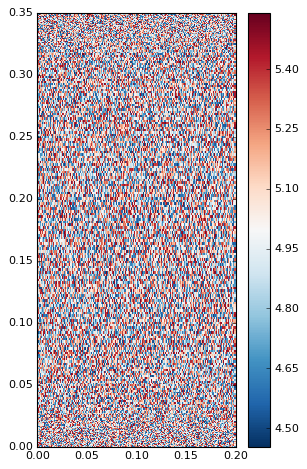

In [31]:
fig, axis = plt.subplots(figsize=(4,7))
p = axis.pcolormesh(xm, ym, T_dat[0].T, cmap='RdBu_r');
plt.colorbar(p)

update init


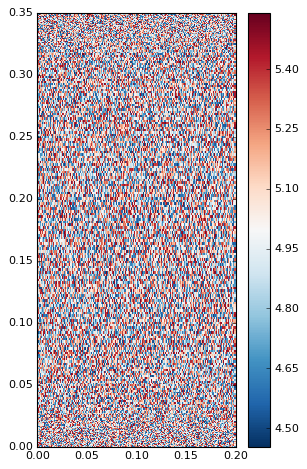

update init


In [32]:
anima = animar_dedalus(xm, ym, T_dat, 'RdBu_r')
mywriter = animation.FFMpegWriter()
anima.save('T_lineal.mp4',writer=mywriter, fps=30)